# LSTM para predecir S&P 500

Machine Learning Avanzado

>  Thamara Lopez, Fabián Ortega

In [118]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import seaborn as sns
import datetime as dt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

Utilizamos los datos de Cierre ajustado del S&P500, además de tomar como feature el Volumen y el VIX. 

In [121]:
dataset_train = pd.read_csv("../data/training_data.csv")
dataset_train['Date'] = pd.to_datetime(dataset_train.loc[:,'Date'])
dataset_train.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,d_volatility,VIX
1242,2021-12-08,4690.859863,4705.060059,4674.520020,4701.209961,4701.209961,3061550000,0.006511,19.90
1243,2021-12-09,4691.000000,4695.259766,4665.979980,4667.450195,4667.450195,2851660000,0.006242,21.58
1244,2021-12-10,4687.640137,4713.569824,4670.240234,4712.020020,4712.020020,2858310000,0.009243,18.69
1245,2021-12-13,4710.299805,4710.299805,4667.600098,4668.970215,4668.970215,3322050000,0.009065,20.31
1246,2021-12-14,4642.990234,4660.470215,4606.520020,4634.089844,4634.089844,3292740000,0.011620,21.89


## Análisis Exploratorio de los datos

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

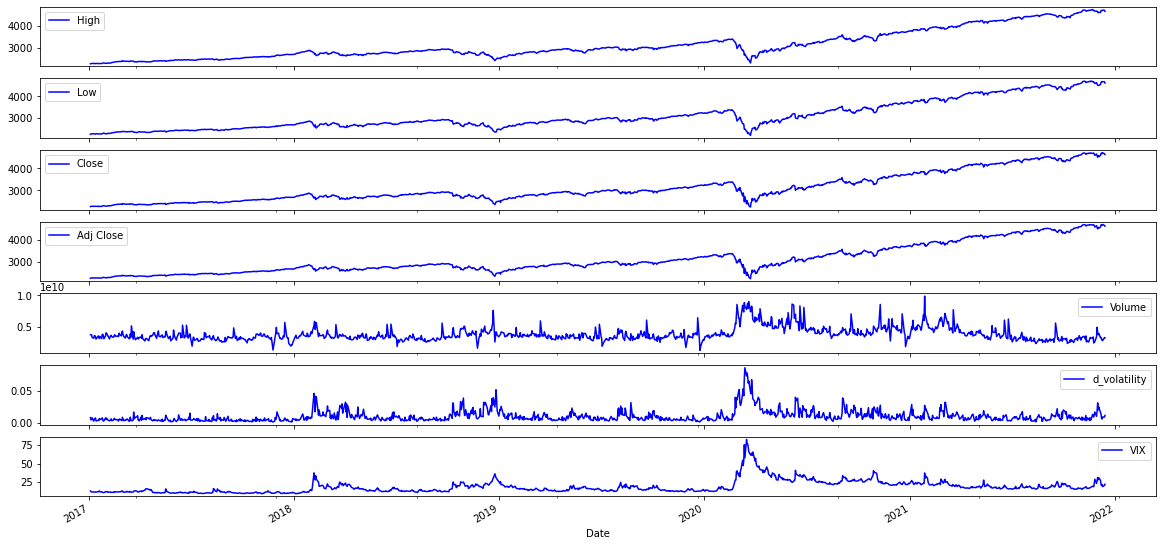

In [122]:
dataset_train.set_index('Date').iloc[:,1:8].plot(subplots=True, color='blue', figsize=(20,10))

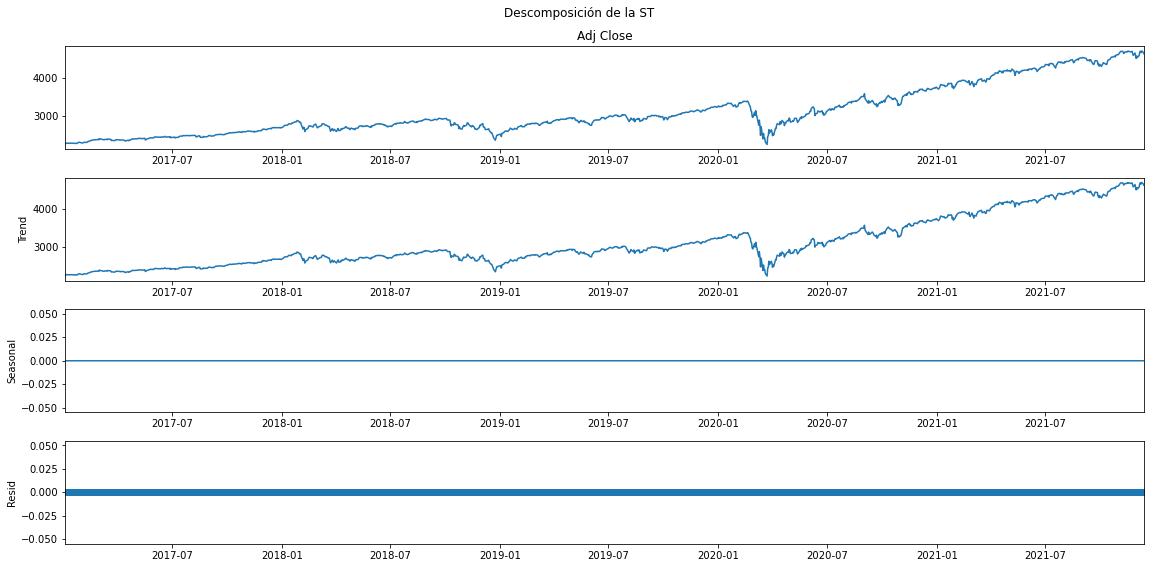

In [123]:
decomposition = seasonal_decompose(
    dataset_train.set_index('Date')['Adj Close'],
    period=1,
    model='additive')

fig = decomposition.plot()
fig.set_size_inches(16, 8)
fig.suptitle('Descomposición de la ST')
fig.tight_layout()

## Preprocesamiento de los datos

In [126]:
dataset_train = pd.read_csv("../data/training_data.csv")
dataset_train = dataset_train[['Date', "Adj Close", "Volume","VIX"]]

In [127]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:4]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1247, 4)
All timestamps == 1247
Featured selected: ['Adj Close', 'Volume', 'VIX']


Preprocesamiento

In [128]:
dataset_train = dataset_train[cols]
dataset_train = dataset_train.astype(float)
# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1247, 3).


array([[2.25783008e+03, 3.77053000e+09, 1.28500000e+01],
       [2.27075000e+03, 3.76489000e+09, 1.18500000e+01],
       [2.26900000e+03, 3.76182000e+09, 1.16700000e+01],
       ...,
       [4.71202002e+03, 2.85831000e+09, 1.86900000e+01],
       [4.66897021e+03, 3.32205000e+09, 2.03100000e+01],
       [4.63408984e+03, 3.29274000e+09, 2.18900000e+01]])

In [129]:
# Feature Scaling
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])  #Y

array([[-1.30859   ],
       [-1.28864641],
       [-1.29134777],
       ...,
       [ 2.47977171],
       [ 2.41331873],
       [ 2.35947633]])

In [130]:
# Dataframe para 16 fechas 1 un output
X_train = []
y_train = []

n_future = 16   # Number of days we want top predict into the future
n_past = 80    # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1152, 80, 2).
y_train shape == (1152, 1).


# Modelo LSTM

In [131]:
def modelo_lstm(trainX,trainY,neuronas, capas, epocas, batch_size,validation_split):

    csv_logger = tf.keras.callbacks.CSVLogger('training.log', separator=',', append=False)

    model = tf.keras.models.Sequential()
    #Entrada
    model.add(tf.keras.layers.LSTM(neuronas ,activation='tanh', input_shape=(n_past, dataset_train.shape[1]-1), return_sequences=True))
    # regularizacion en las conexiones de entrada
    model.add(tf.keras.layers.Dropout(0.2)) 
   
    #second LSTM
    for i in range(capas):
        model.add(tf.keras.layers.LSTM(units=32, return_sequences = False))
        model.add(tf.keras.layers.Dropout(0.2)) 
    
   
    # Salida
    model.add(tf.keras.layers.Dense(trainY.shape[1], activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01) , loss="mean_squared_error")
    model.summary()

    #definir "early stopping" la loss de validacion no mejora en X épocas
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=50,  #numero de epocas sin mejora
                                                      restore_best_weights = True)
    tb = tf.keras.callbacks.TensorBoard('logs')
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, verbose=1)
    mcp = tf.keras.callbacks.ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    history = model.fit(trainX, trainY,epochs=epocas, batch_size=batch_size, validation_split=validation_split, verbose=1, callbacks=[early_stopping, csv_logger, tb, rlr, mcp])

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.ylabel("Error")
    plt.xlabel("Epocas")
    plt.legend()
    return model
    

# Entrenamiento

2022-01-27 21:03:08.930718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-27 21:03:08.932154: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 64)            17152     
                                                                 
 dropout (Dropout)           (None, 80, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
__________________________________________

2022-01-27 21:03:09.377142: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-27 21:03:10.663607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 21:03:10.886759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 21:03:11.040409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 21:03:11.227571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 21:03:11.488162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - ETA: 0s - loss: 0.4649

2022-01-27 21:03:15.211038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 21:03:15.280201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 21:03:15.386207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 4.26456, saving model to weights.h5
65/65 [==============================] - 6s 63ms/step - loss: 0.4649 - val_loss: 4.2646 - lr: 0.0100
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.4252
Epoch 00002: val_loss improved from 4.26456 to 2.62148, saving model to weights.h5
65/65 [==============================] - 3s 45ms/step - loss: 0.4252 - val_loss: 2.6215 - lr: 0.0100
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.3297
Epoch 00003: val_loss did not improve from 2.62148
65/65 [==============================] - 3s 44ms/step - loss: 0.3297 - val_loss: 2.8988 - lr: 0.0100
Epoch 4/200
65/65 [==============================] - ETA: 0s - loss: 0.2082
Epoch 00004: val_loss improved from 2.62148 to 2.53077, saving model to weights.h5
65/65 [==============================] - 3s 45ms/step - loss: 0.2082 - val_loss: 2.5308 - lr: 0.0100
Epoch 5/200
65/65 [==============================] - ETA: 0s - loss: 0.

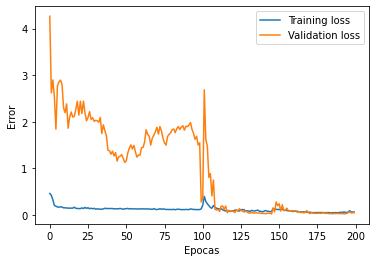

In [132]:
modelo = modelo_lstm(X_train, y_train, 64, capas=1,epocas=200, batch_size=16,validation_split=0.1)

# Forecasting

In [133]:
# Se genera lista con los días a predecir
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Timestap a Datetime object
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [134]:
# Preddiciones

predictions_future = modelo.predict(X_train[-n_future:])
predictions_train = modelo.predict(X_train[n_past:])

2022-01-27 21:15:24.638157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 21:15:24.716280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 21:15:24.855470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Transformación inversa de los datos (escalado inverso)

In [135]:
#  <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    ''' Convierte x a timestamp'''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Adj Close']).set_index(pd.Series(datelist_future))
#PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Adj Close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

PREDICTIONS_FUTURE.index = PREDICTIONS_FUTURE.index.to_series().apply(datetime_to_timestamp)

PREDICTIONS_FUTURE.head(3)

,Adj Close
2021-12-14,4632.317383
2021-12-15,4614.268066
2021-12-16,4614.019531


Export para binnario

Las fechas no corresponden, pero si el número de observaciones. 

In [137]:
df_to_binnario = PREDICTIONS_FUTURE[0:]
df_to_binnario.to_csv("../output/predict.csv",index=False, header= False)

# Estimación usando Prophet 

In [144]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

In [145]:
df_prophet = pd.read_csv("../data/training_data.csv")
df_prophet = df_prophet[['Date', 'Adj Close']].rename(columns={'Date':'ds', 'Adj Close': 'y'})
df_prophet.tail()

,ds,y
1242,2021-12-08,4701.209961
1243,2021-12-09,4667.450195
1244,2021-12-10,4712.020020
1245,2021-12-13,4668.970215
1246,2021-12-14,4634.089844


In [146]:
m = Prophet(daily_seasonality = True) 
m.fit(df_prophet)

Initial log joint probability = -7.74658


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3990.81    0.00798059       848.918      0.6638      0.6638      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4061.42    0.00343907       1200.94           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4092.88    0.00303077       570.592           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4129.34     0.0220671       786.648           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4147.86    0.00128999        295.29           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

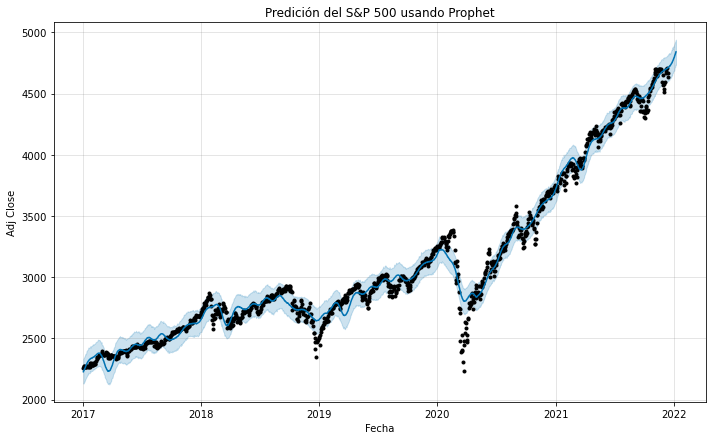

In [147]:
future = m.make_future_dataframe(periods=25) 
prediction = m.predict(future)
m.plot(prediction)
plt.title("Predición del S&P 500 usando Prophet")
plt.xlabel("Fecha")
plt.ylabel("Adj Close")
plt.show()

# Comparación de modelos

Error cuadrático medio vs datos reales del S&P500

In [140]:
# Obtenemos datos reales
import yfinance as yf
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="1y")
sp500.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-21,4471.379883,4494.520020,4395.339844,4397.939941,3945810000,0,0
2022-01-24,4356.319824,4417.350098,4222.620117,4410.129883,5172540000,0,0
2022-01-25,4366.640137,4411.009766,4287.109863,4356.450195,3989420000,0,0
2022-01-26,4408.430176,4453.229980,4304.799805,4349.930176,4046270000,0,0
2022-01-27,4380.580078,4428.740234,4309.500000,4326.509766,3040759000,0,0


Datos reales del S&P 500

In [141]:
sp500 = sp500[sp500.index > "2021-12-14"].Close[0:16]
dates = sp500.reset_index()['Date']
sp500 = sp500.reset_index()
sp500

,Date,Close
0,2021-12-15,4709.850098
1,2021-12-16,4668.669922
2,2021-12-17,4620.640137
3,2021-12-20,4568.020020
4,2021-12-21,4649.229980
5,2021-12-22,4696.560059
6,2021-12-23,4725.790039
7,2021-12-27,4791.189941
8,2021-12-28,4786.350098
9,2021-12-29,4793.060059


Datos de Prophet

In [148]:
prediction = prediction[prediction.ds > "2021-12-14"].yhat[0:16].reset_index().drop("index", axis=1)
prophet_predict = pd.DataFrame(data={'Date':dates, "predict":prediction.yhat})
prophet_predict = prophet_predict.rename(columns={"predict":"prophet_predict"})
prophet_predict

,Date,prophet_predict
0,2021-12-15,4713.291112
1,2021-12-16,4715.250888
2,2021-12-17,4718.824481
3,2021-12-20,4721.067021
4,2021-12-21,4723.729515
5,2021-12-22,4723.210451
6,2021-12-23,4730.119387
7,2021-12-27,4732.303319
8,2021-12-28,4735.865934
9,2021-12-29,4741.218628


Datos de LSTM

In [150]:
lstm_predict = pd.read_csv("../output/predict.csv", header=None)
lstm_predict = pd.DataFrame(data={'Date':dates, 'lstm_predict':lstm_predict[0]})
lstm_predict

,Date,lstm_predict
0,2021-12-15,4632.3174
1,2021-12-16,4614.2680
2,2021-12-17,4614.0195
3,2021-12-20,4599.0366
4,2021-12-21,4618.2090
5,2021-12-22,4601.7095
6,2021-12-23,4506.9010
7,2021-12-27,4593.1100
8,2021-12-28,4654.8813
9,2021-12-29,4640.0780


In [154]:
data_mse = pd.merge(sp500, lstm_predict).merge(prophet_predict)
data_mse

,Date,Close,lstm_predict,prophet_predict
0,2021-12-15,4709.850098,4632.3174,4713.291112
1,2021-12-16,4668.669922,4614.2680,4715.250888
2,2021-12-17,4620.640137,4614.0195,4718.824481
3,2021-12-20,4568.020020,4599.0366,4721.067021
4,2021-12-21,4649.229980,4618.2090,4723.729515
5,2021-12-22,4696.560059,4601.7095,4723.210451
6,2021-12-23,4725.790039,4506.9010,4730.119387
7,2021-12-27,4791.189941,4593.1100,4732.303319
8,2021-12-28,4786.350098,4654.8813,4735.865934
9,2021-12-29,4793.060059,4640.0780,4741.218628


In [159]:
from sklearn.metrics import mean_squared_error

print(f"El ECM del modelo LSTM es {mean_squared_error(data_mse.Close.values, data_mse.lstm_predict.values)}")
print(f"El ECM del modelo Prophet es {mean_squared_error(data_mse.Close.values, data_mse.prophet_predict.values)}")



El ECM del modelo LSTM es 13755.848595665142
El ECM del modelo Prophet es 4039.280111401654


El Error cuadrático medio del modelo Prophet es menor que del modelo usando LSTM.